In [85]:
cd(@__DIR__)
include("table_reader.jl")

extract_series (generic function with 1 method)

In [86]:
series=extract_series("TX_STAID000031.txt",plot=false)
years=unique(Dates.year.(series.DATE))

#Imputing missing values
include("utils/Missing_values.jl")
ImputeMissingValues!(series[!,2],series.DATE)
N=length(series[!,2])

47 days imputated into the series


38805

## I. Series filtered by removing a trigonometric periodicity

In [87]:
include("utils/periodicity.jl")
trigo_function=fitted_periodicity(series[!,2])
periodicity=trigo_function.(1:N)
x=series[!,2]-periodicity

38805-element Vector{Float64}:
  0.1571733303306786
  0.9025807554782155
  1.6455685571830738
 -1.1138759858801954
  2.7242351247636574
  0.35989061094215913
  4.293079921172671
  3.923793233784849
  3.552021459827193
  4.67775624575669
  ⋮
  3.1148196390843523
  0.9855756895720891
 -0.544869543313574
 -1.4764774570800157
  0.3907908948334349
  3.1569747915353403
  3.522113833055723
  1.9862479286246106
  2.5494172848670615

## Segmenting the dataset by month

In [88]:
include("utils/Separation.jl")
Monthly_date=MonthlySeparateDates(series.DATE)
Monthly_temp=MonthlySeparateX(x,series.DATE)

12-element Vector{Vector{Any}}:
 [[0.1571733303306786, 0.9025807554782155, 1.6455685571830738, -1.1138759858801954, 2.7242351247636574, 0.35989061094215913, 4.293079921172671, 3.923793233784849, 3.552021459827193, 4.67775624575669  …  -2.009942466426878, -8.517044422764606, -11.0266785663819, -7.2388420462589, -0.6535312628724856, -0.17074186926148194, -5.990468772313045, -6.012706134269859, -3.6374473744577056, -5.164685171232865], [-0.1541868374230706, 0.9918046262596878, 4.335379655465964, 2.776525355092838, 2.615229548945779, 0.9514807833419603, 1.185268330499726, 1.6165821917132508, 1.2454131003114384, 1.9717525244002  …  2.991396457136771, 5.084908141202829, 1.1758870601695488, 4.464335883633966, 1.450258029921045, 1.633657665072123, 3.71453970161204, 1.5929097970953858, -0.43122564756771986, 4.842140509994145], [-1.6656879601397154, 3.7808867436742304, -2.2749517560731967, 0.4667834719614383, 4.406080077125212, 4.142926430423776, 2.877311627962703, 3.1092254941742414, 3.53865858

## Autocorrelations

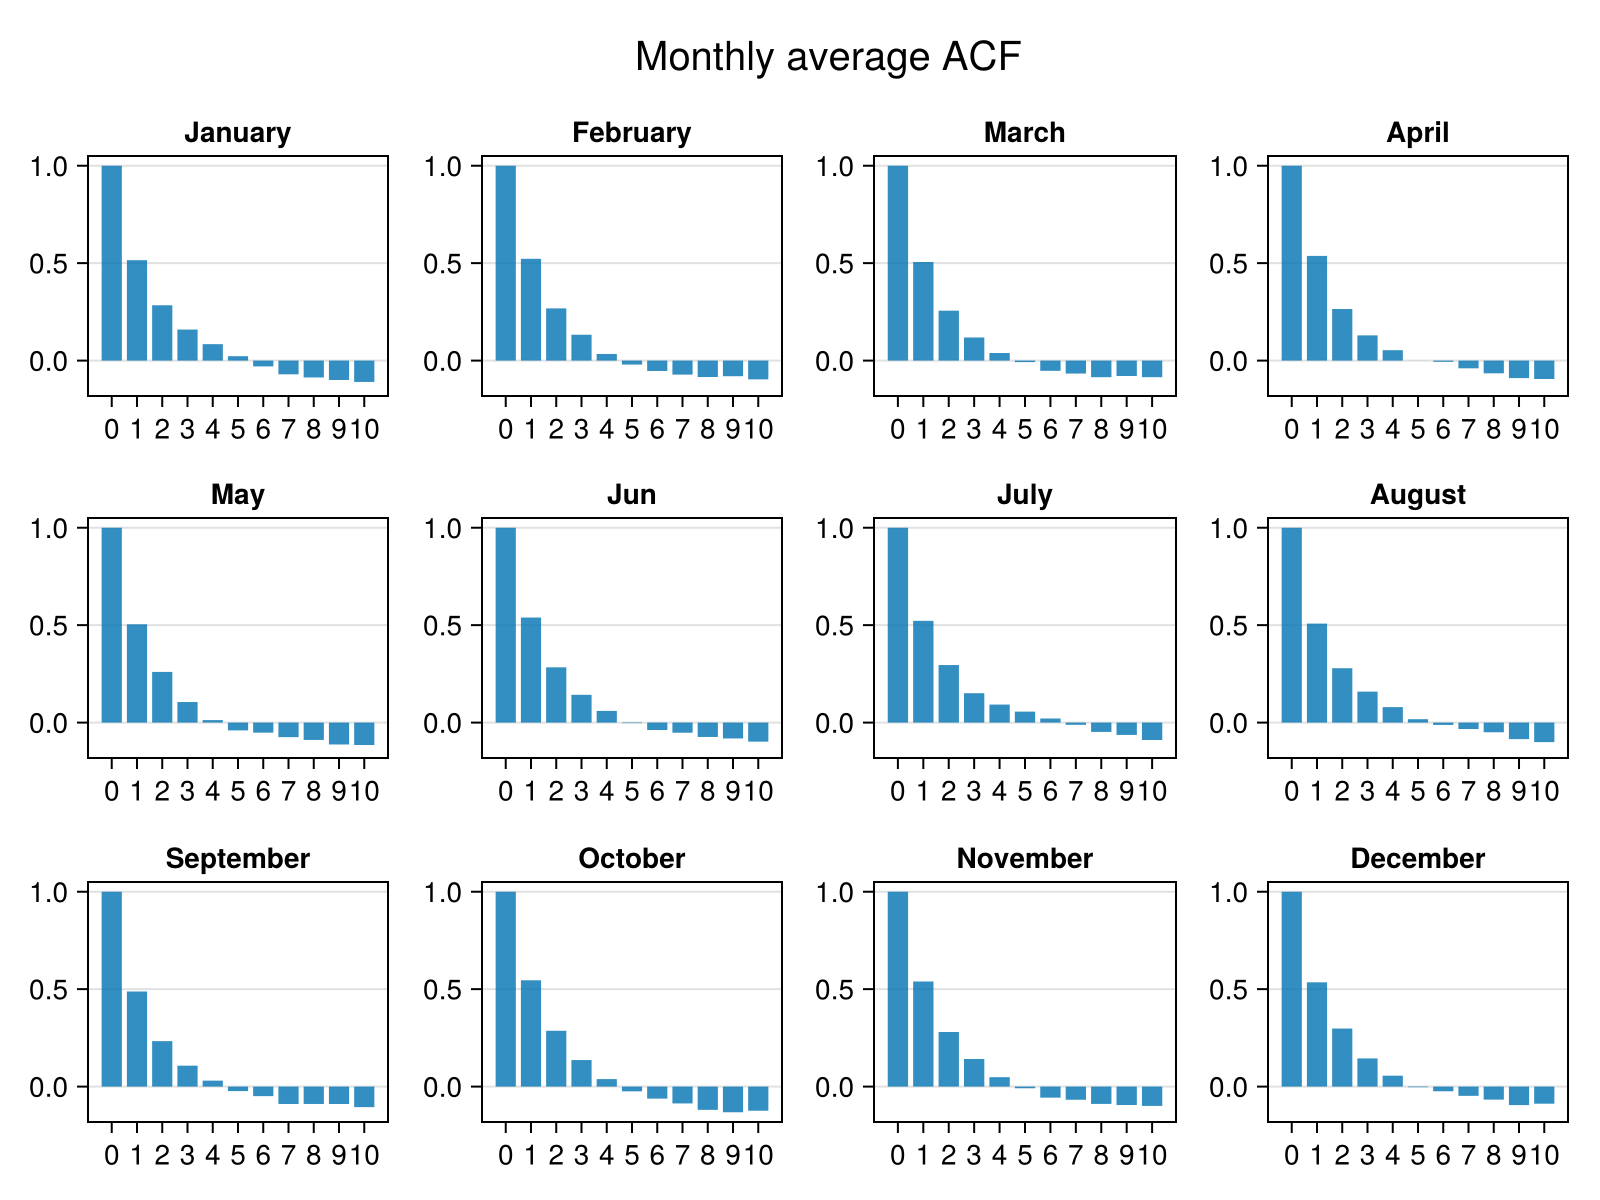

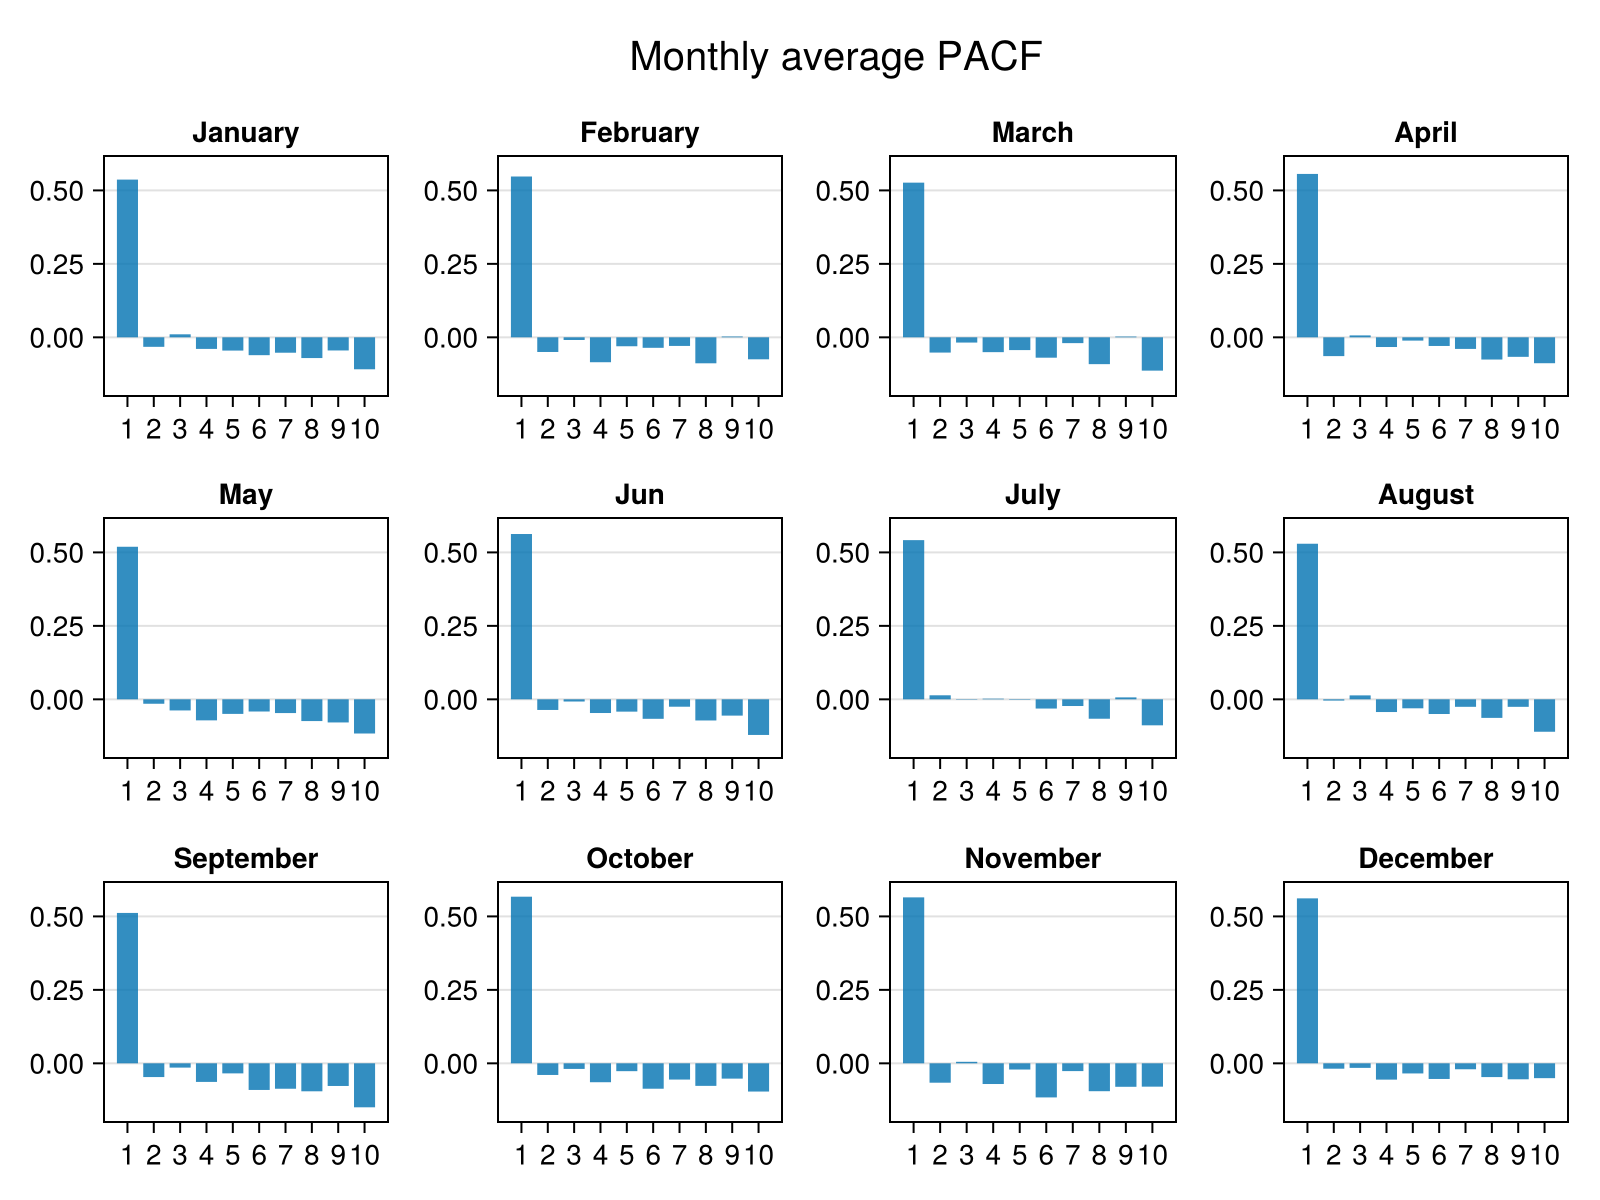

CairoMakie.Screen{IMAGE}


In [89]:
include("utils/ACF_PACF.jl")
display(MonthlyACF(Monthly_temp))
display(MonthlyPACF(Monthly_temp))

For each month, it still looks like an AR(1) model

# Estimation AR(1)

## Estimation

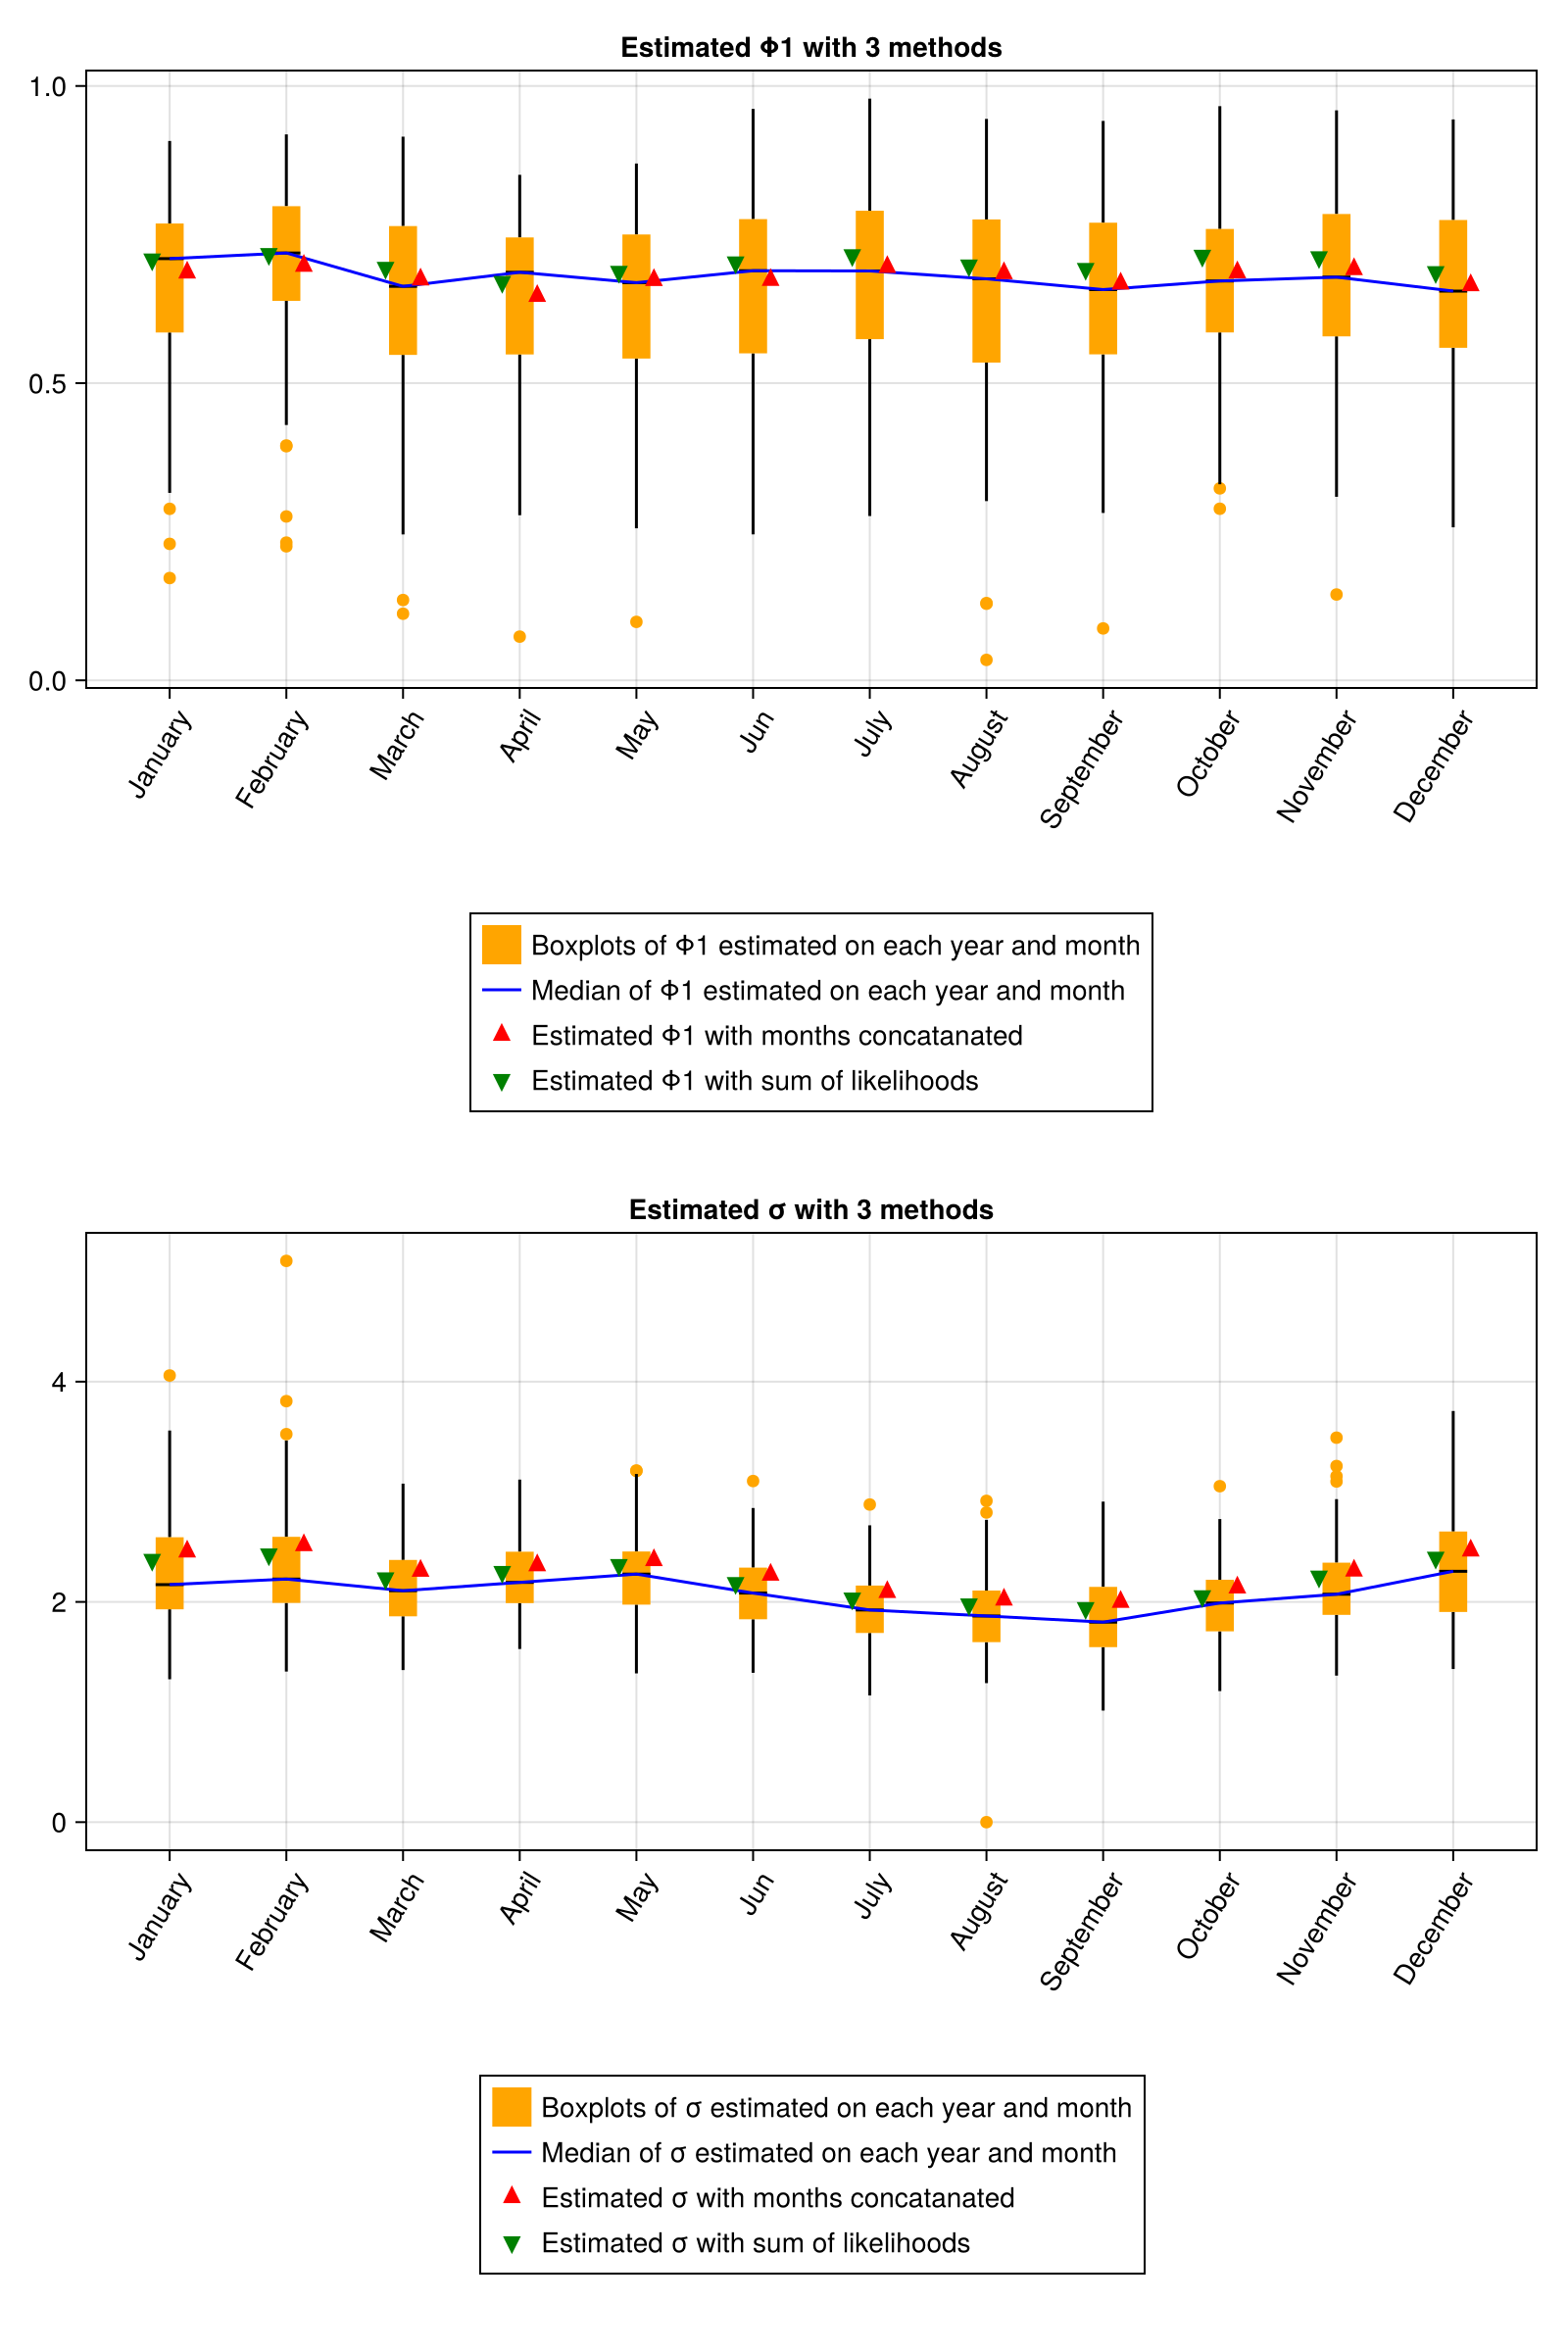

CairoMakie.Screen{IMAGE}


In [90]:
include(raw"utils\Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, lineplot=true)
display(figure)

## Simulation

### With estimation on each month

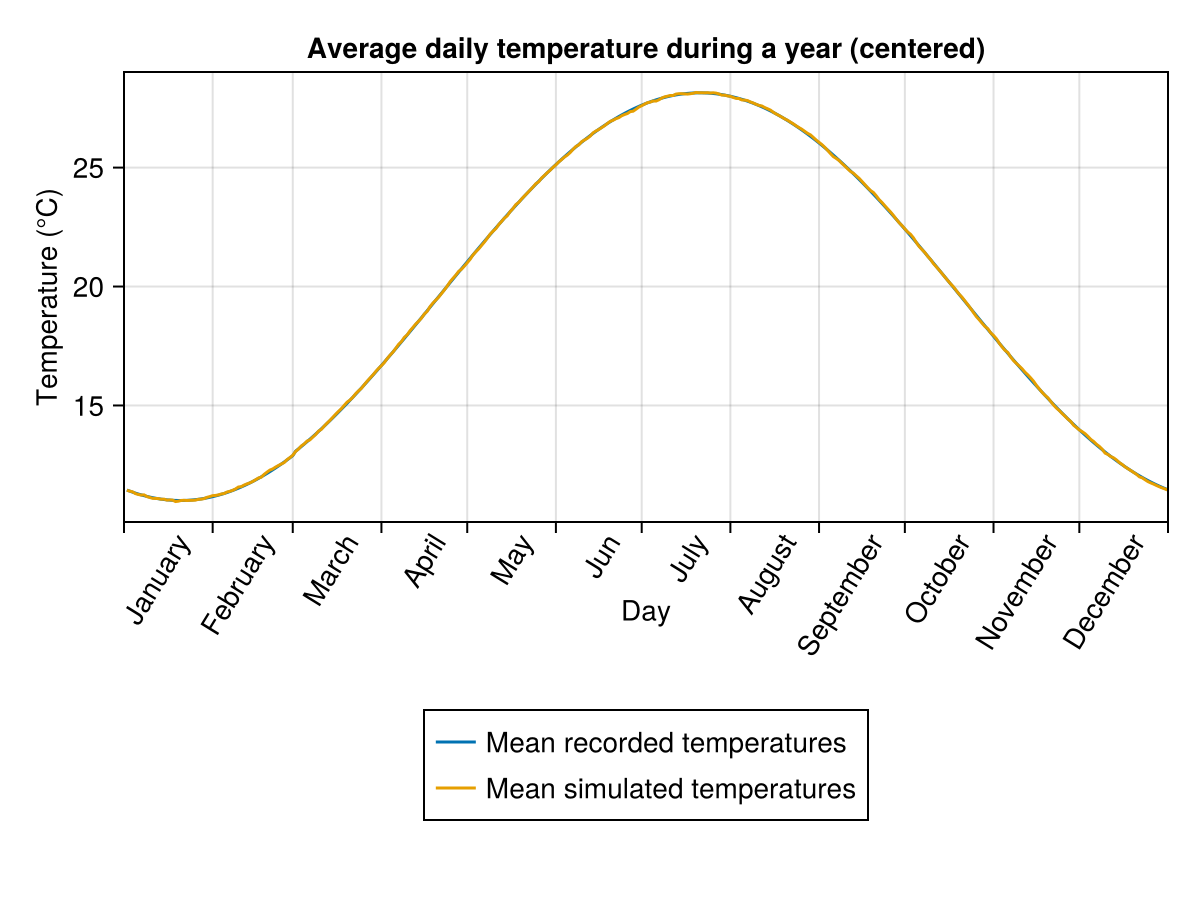

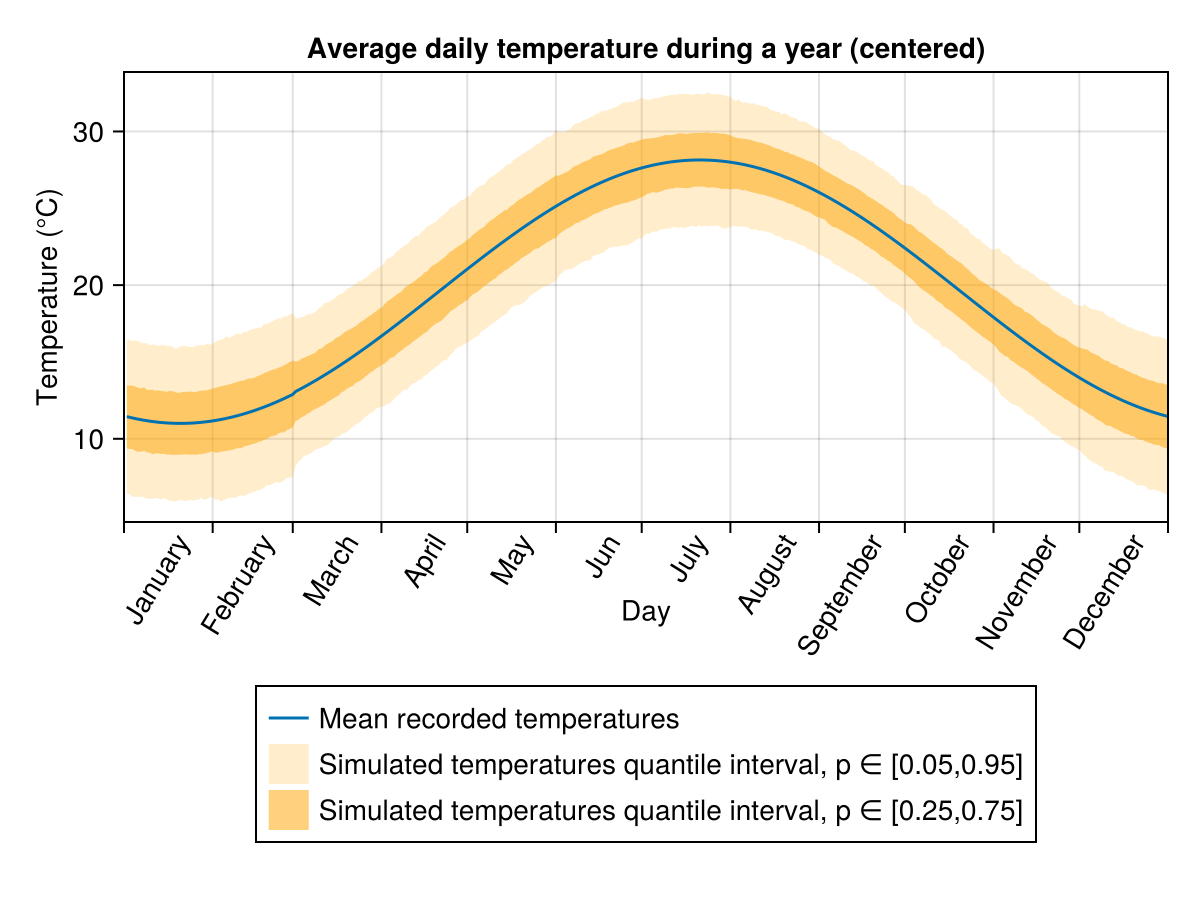

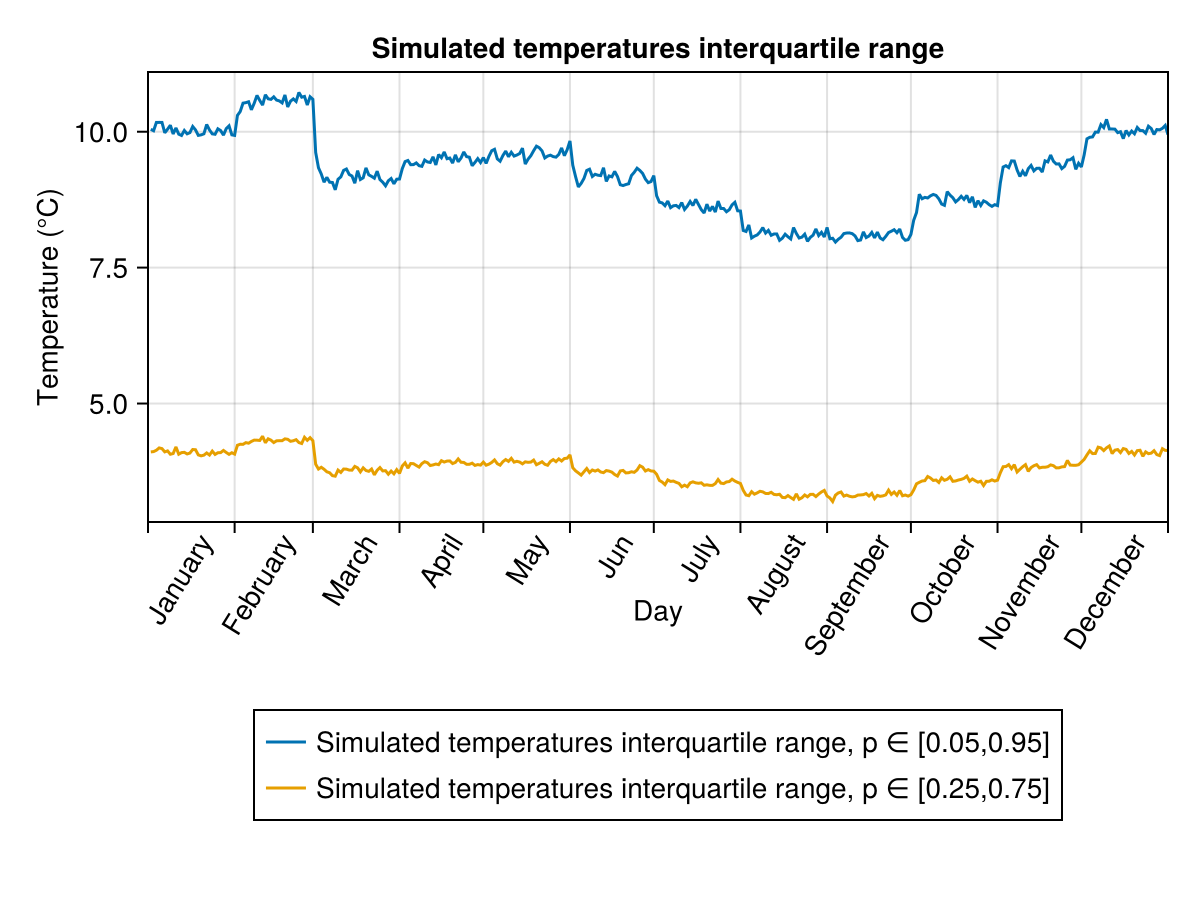

CairoMakie.Screen{IMAGE}


In [91]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"mean")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

We see clearly that interquartile range is shorter during summer and larger during winter.

### With months concatanation

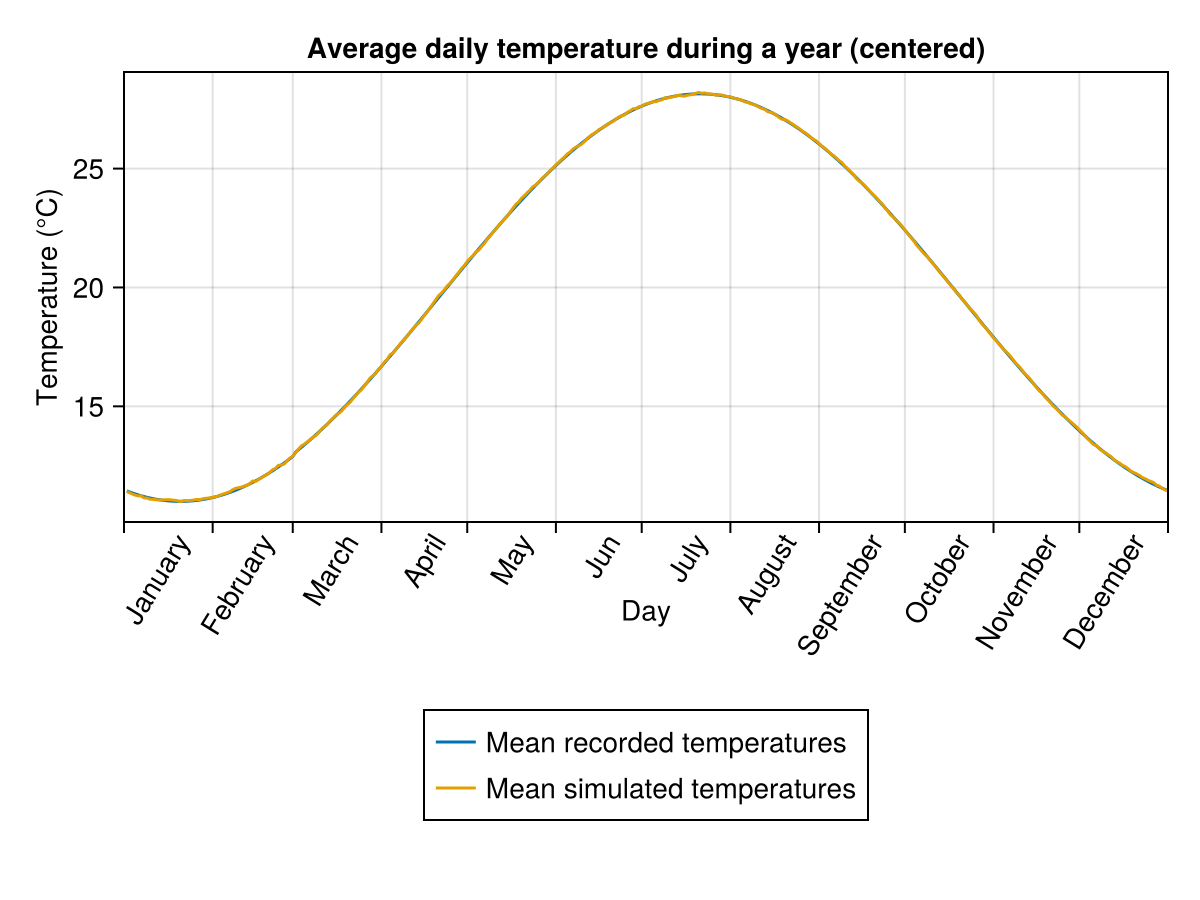

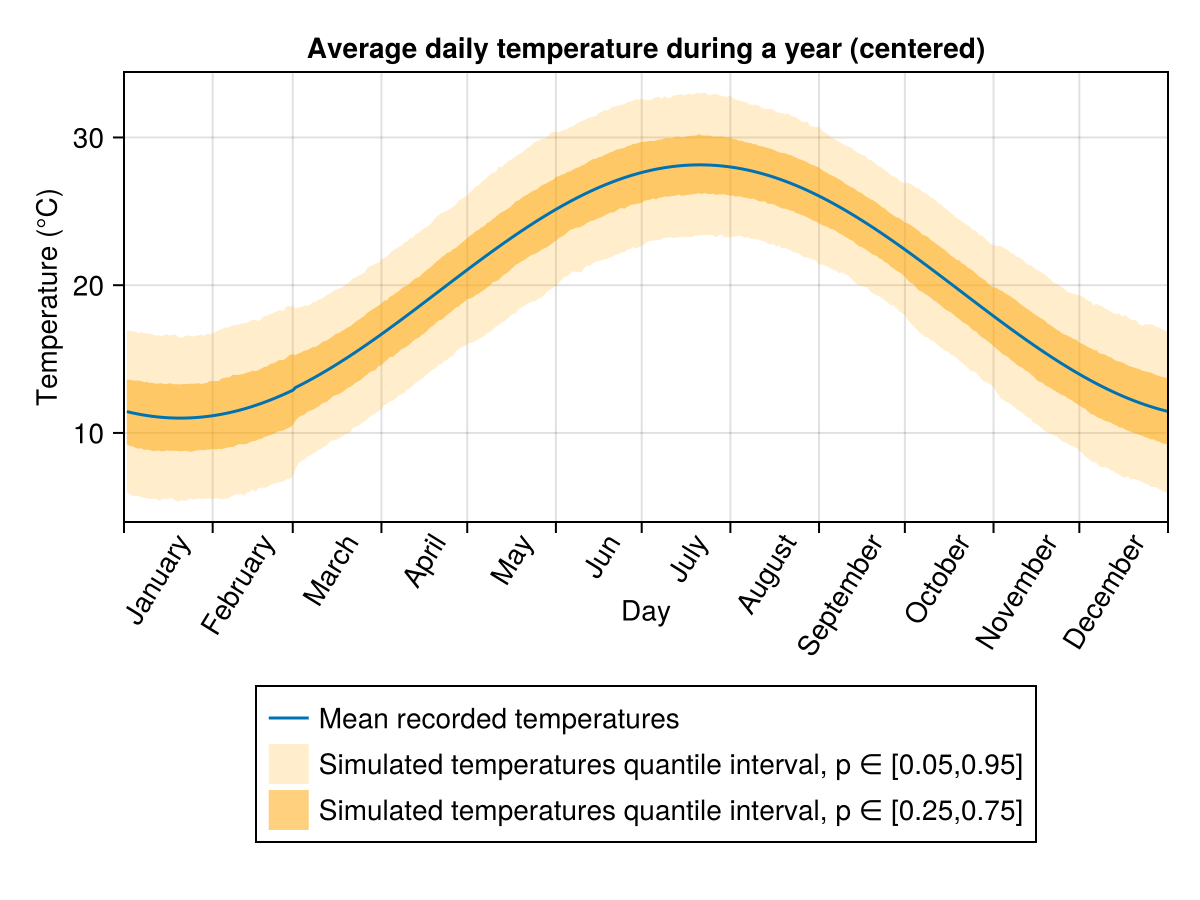

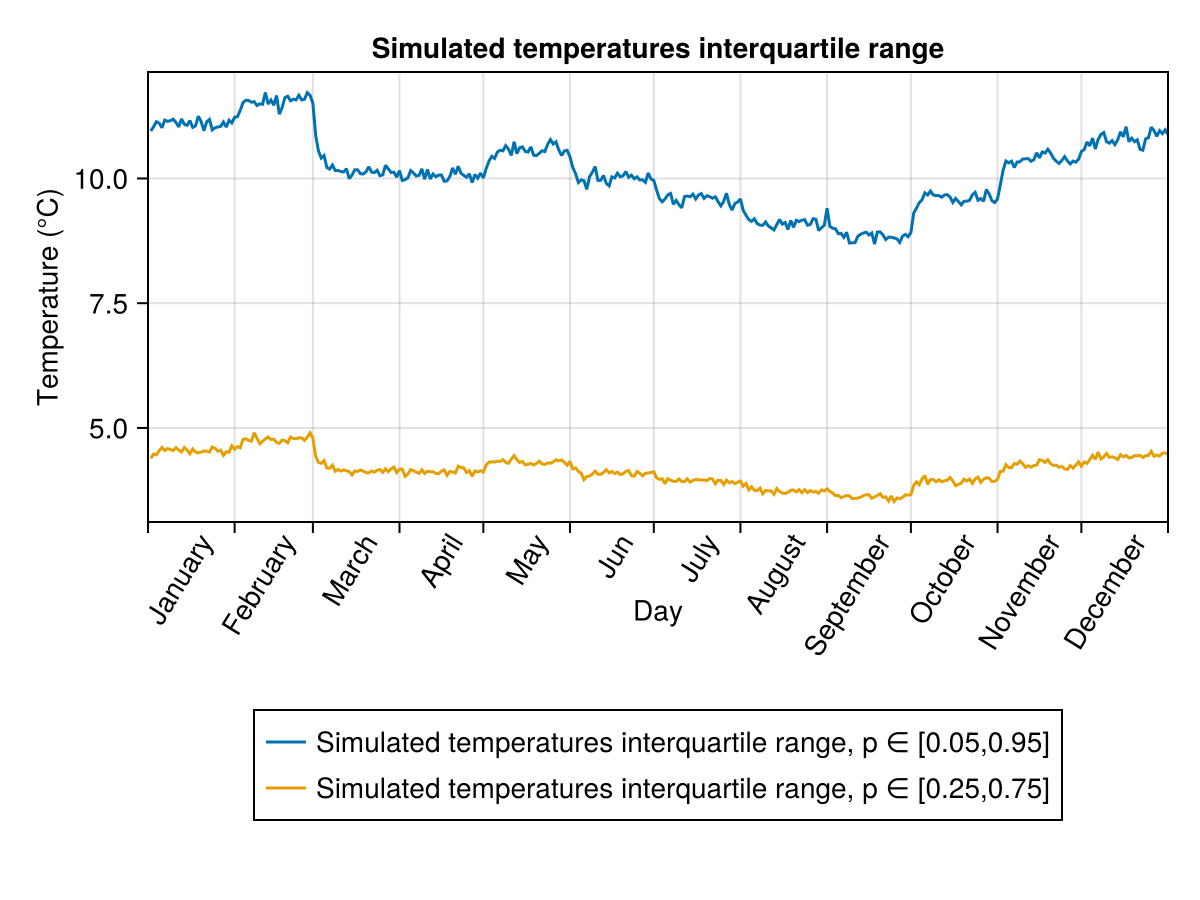

CairoMakie.Screen{IMAGE}


In [92]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"concat")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

### With sum of likelihoods

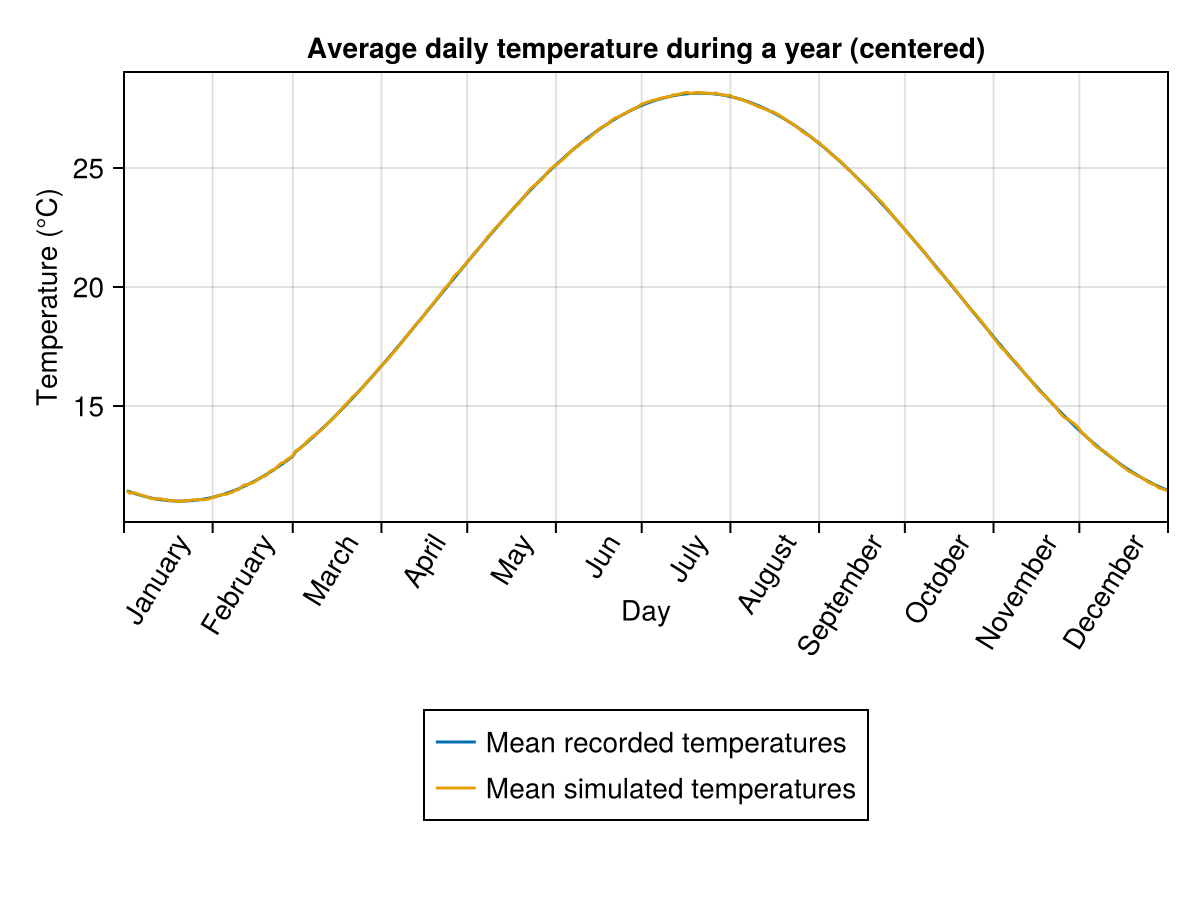

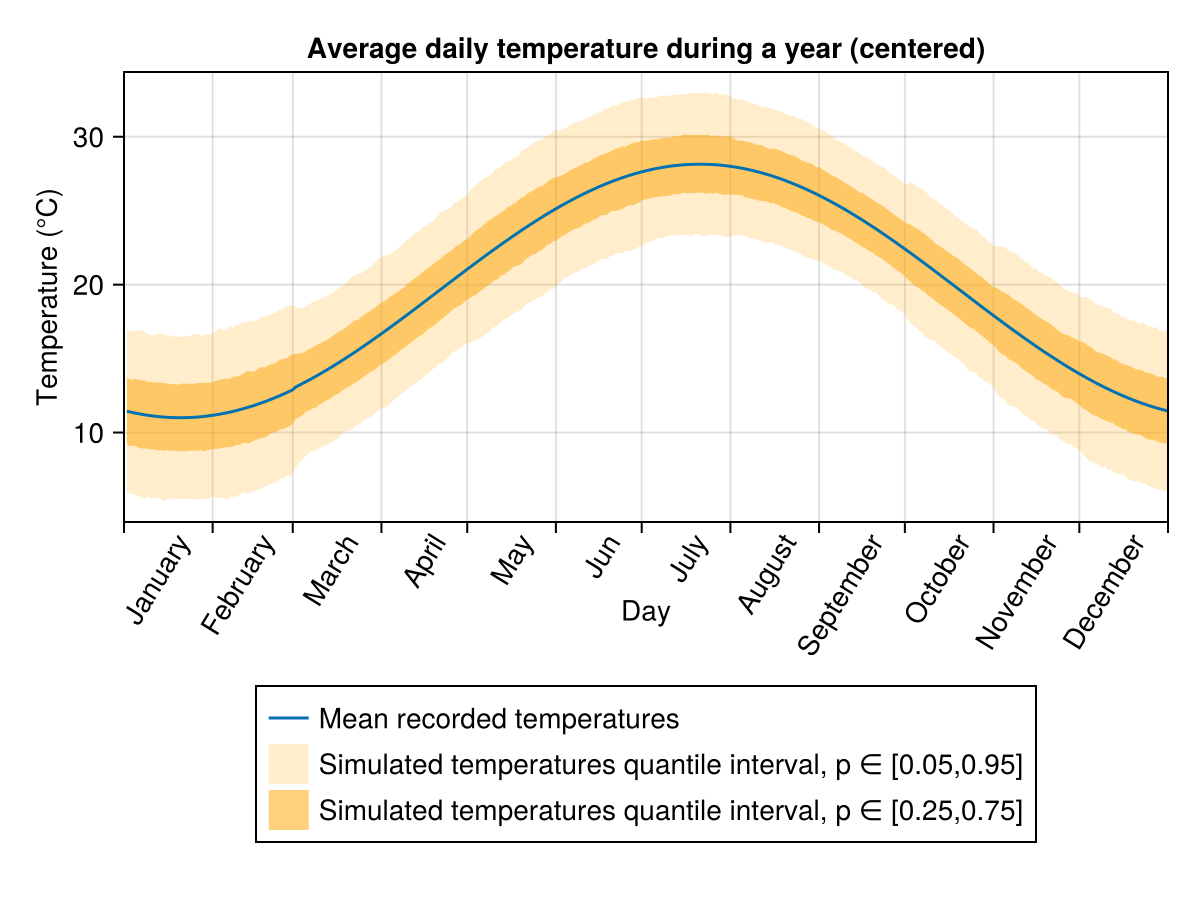

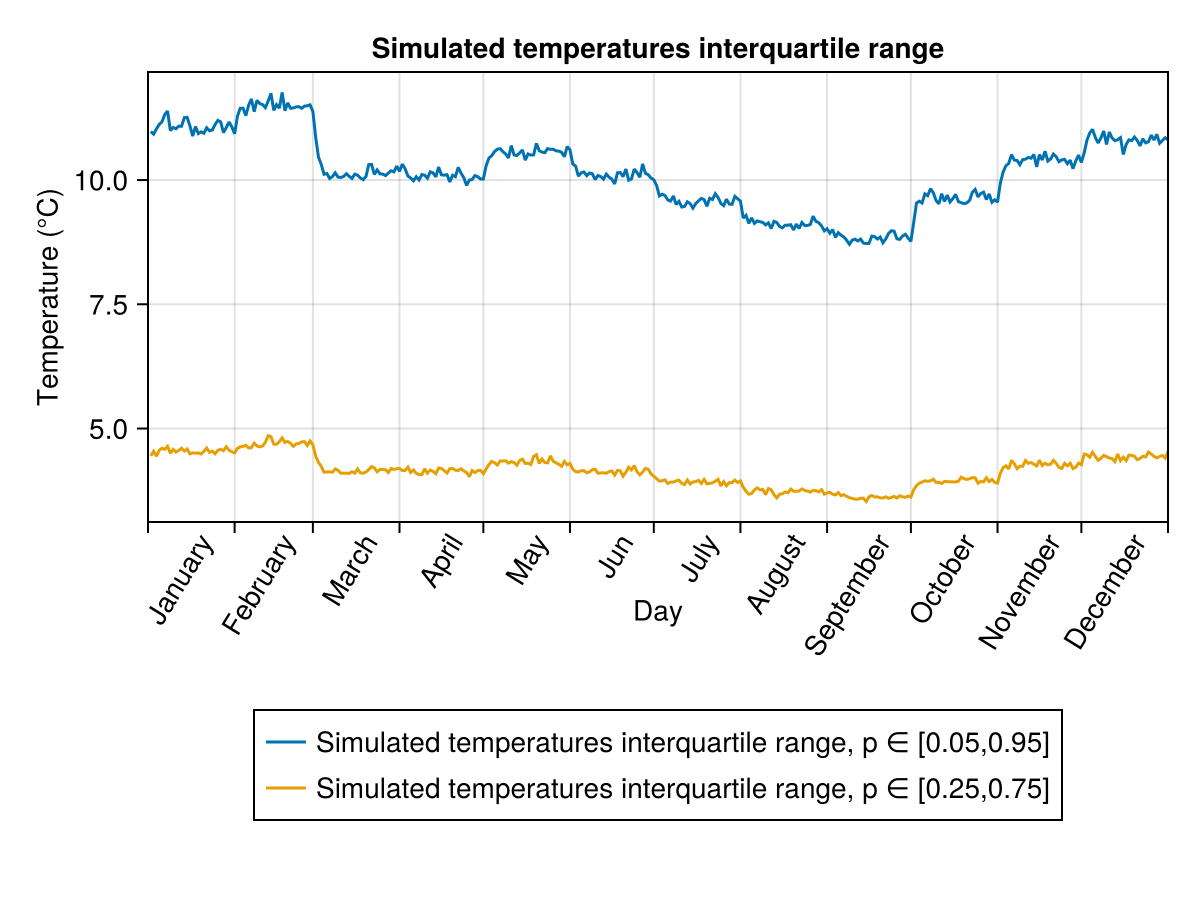

CairoMakie.Screen{IMAGE}


In [93]:
include("utils/Simulation.jl")
period=[periodicity[1:59] ; periodicity[61:366]]
Φ_month_mean,σ_month_mean=TakeParameters(Params,"sumLL")
sample_ = SimulateYears(Monthly_temp[1][1][1],series.DATE[1],Φ_month_mean,σ_month_mean, 100 * 105)
sample_ = invert(sample_ + repeat([period],length(sample_))) 
display(PlotYearCurves([period,mean.(sample_)],["Mean recorded temperatures","Mean simulated temperatures"],"Average daily temperature during a year (centered)"))
display(PlotYearCurves(period,
["Mean recorded temperatures","Simulated temperatures quantile interval, p ∈ [0.05,0.95]","Simulated temperatures quantile interval, p ∈ [0.25,0.75]"],
"Average daily temperature during a year (centered)",
[(quantile.(sample_,0.05),quantile.(sample_,0.95)),(quantile.(sample_,0.25),quantile.(sample_,0.75))],
[("orange",0.2),("orange",0.5)]
))
display(PlotYearCurves([quantile.(sample_,0.95) .- quantile.(sample_,0.05) , quantile.(sample_,0.75) .- quantile.(sample_,0.25)],
["Simulated temperatures interquartile range, p ∈ [0.05,0.95]" ,"Simulated temperatures interquartile range, p ∈ [0.25,0.75]"],
"Simulated temperatures interquartile range"
))

# Estimation AR(2)

## Estimation

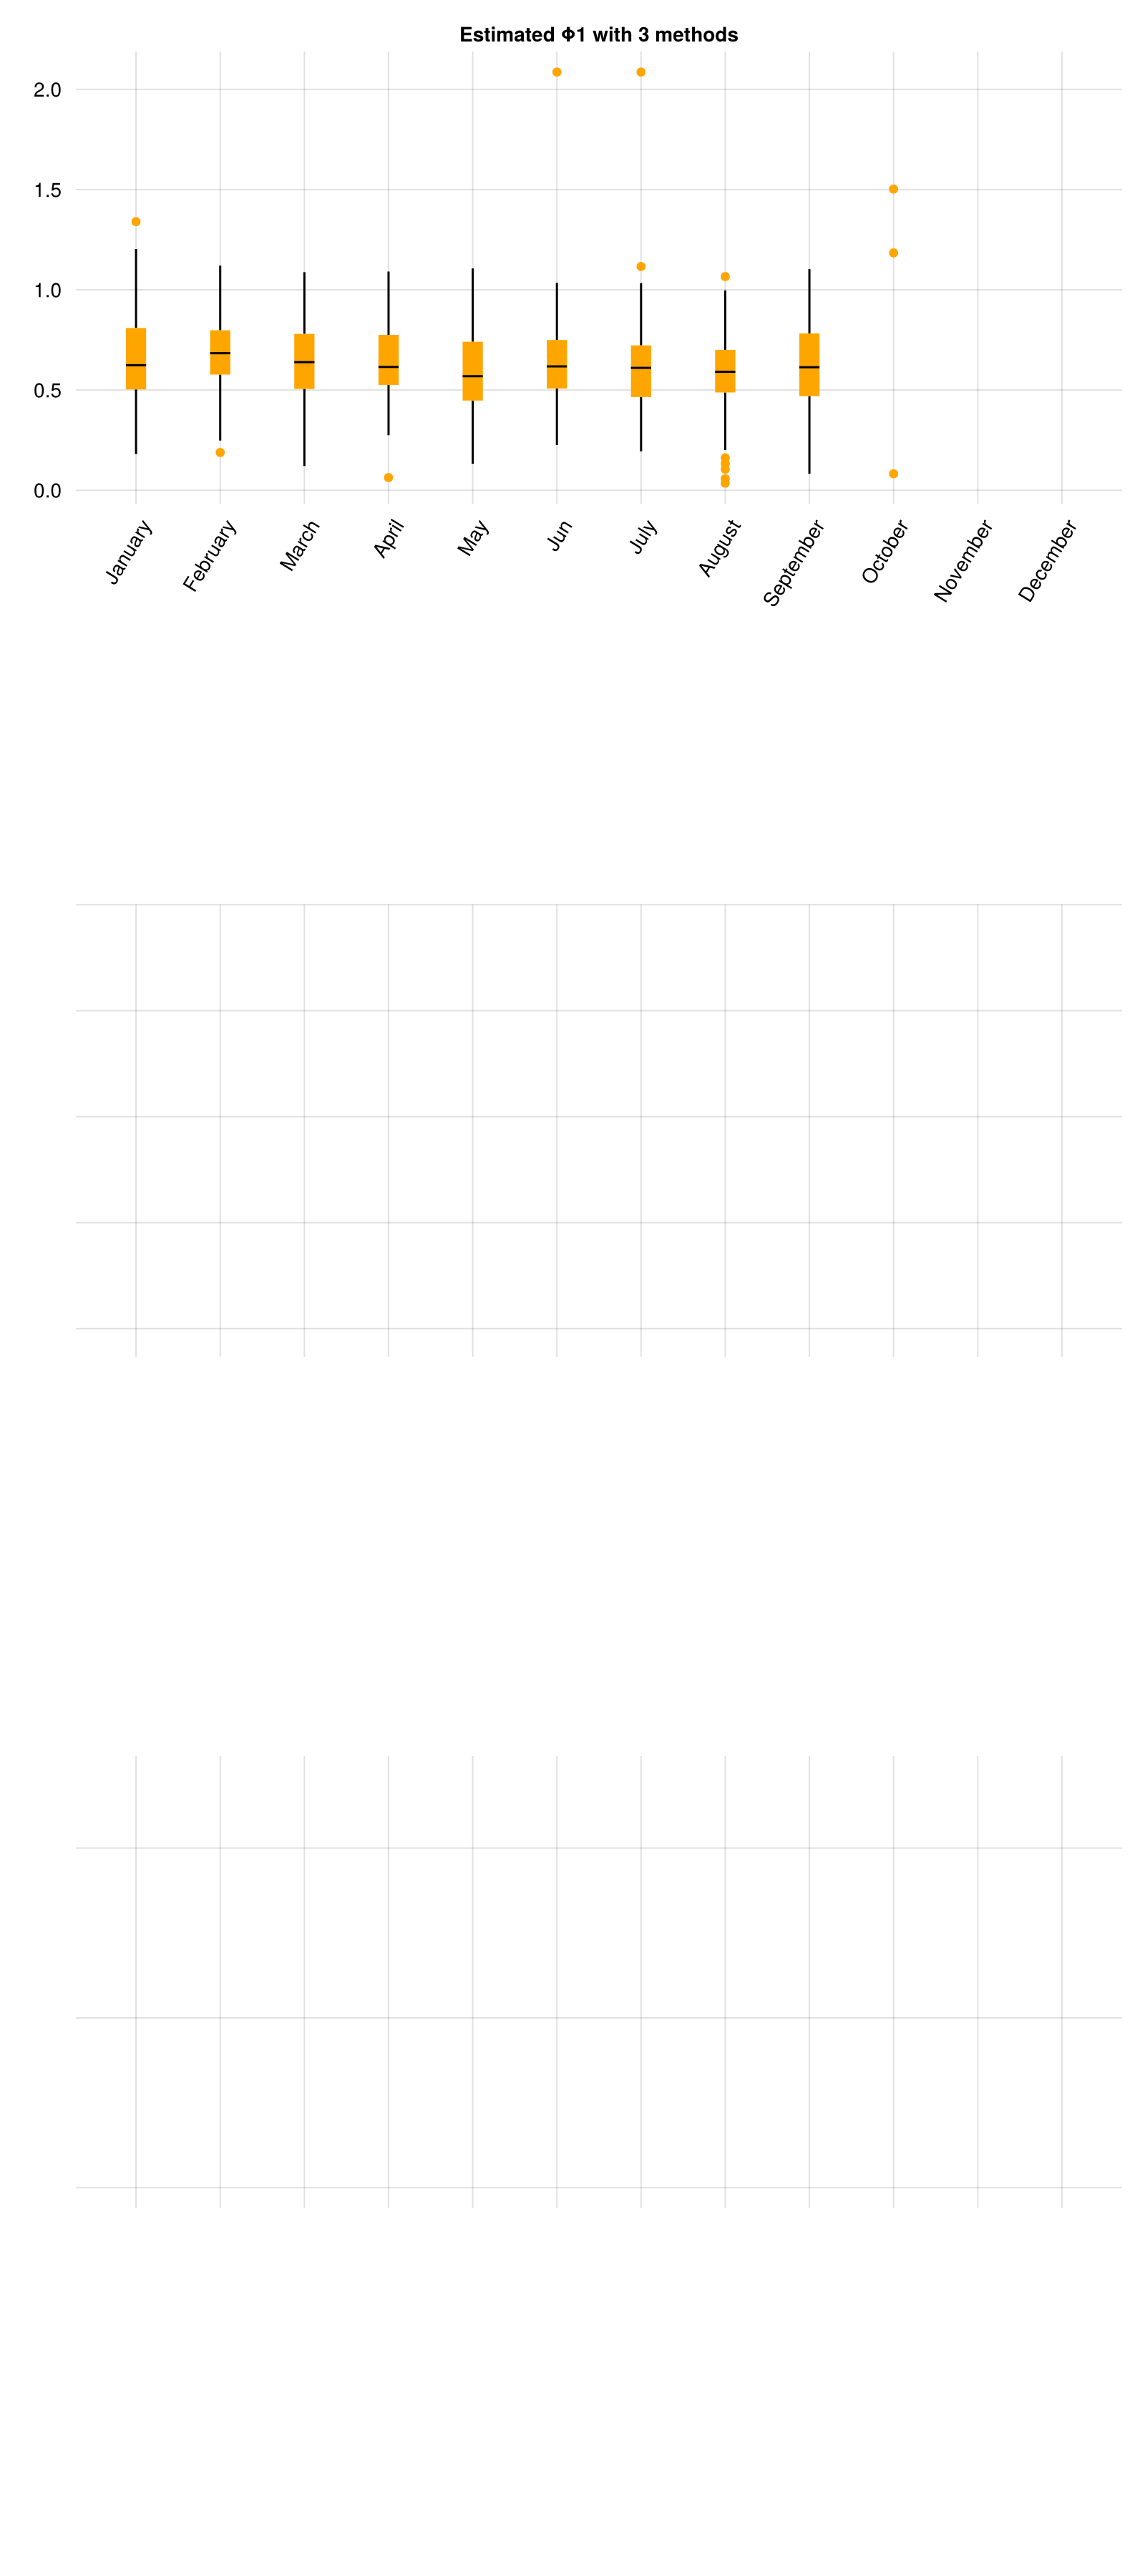

CairoMakie.Screen{IMAGE}


In [98]:
include(raw"utils\Estimation.jl")
Params, figure= AllEstimation(Monthly_temp, 2, lineplot=true)
display(figure)